In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.seasonal import STL


In [185]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [186]:
# data = pdr.get_data_fred('HOUSTNSA', '1959-01-01', '2019-06-01')
# housing = data.HOUSTNSA.pct_change().dropna()
data = pd.read_csv('daily_data.csv')
data.index = pd.to_datetime(data.date)
data['prexmas'] = data.index.week.isin([50,51]).astype(int)
data['xmas'] = data.index.week.isin([52,1]).astype(int)
data['dow'] = data.index.dayofweek
data['we'] = data.dow.isin([5,6]).astype(int)
data = data['2018-02-12':]
data = data.asfreq('d')
data.head(10)

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,week,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,
2018-02-12,2018-02-12,24.99,2.0,0.040417,2.944444,0.0,0.0,0.0,32.0,0.000000,2018_07,0,0,0,0
2018-02-13,2018-02-13,24.99,2.0,0.040417,4.166667,4.0,0.0,4.0,32.0,0.125000,2018_07,0,0,1,0
2018-02-14,2018-02-14,24.99,0.0,0.040417,3.333333,2.0,2.0,6.0,34.0,0.176471,2018_07,0,0,2,0
2018-02-15,2018-02-15,24.99,0.0,0.040417,7.277778,2.0,-2.0,8.0,32.0,0.250000,2018_07,0,0,3,0
2018-02-16,2018-02-16,24.99,1.0,0.040417,4.666667,2.0,0.0,10.0,32.0,0.312500,2018_07,0,0,4,0
2018-02-17,2018-02-17,24.99,2.0,0.040417,5.666667,0.0,1.0,10.0,33.0,0.303030,2018_07,0,0,5,1
2018-02-18,2018-02-18,24.99,0.0,0.040417,6.055556,0.0,-1.0,10.0,32.0,0.312500,2018_07,0,0,6,1
2018-02-19,2018-02-19,24.99,0.0,1.874545,8.944444,1.0,0.0,11.0,32.0,0.343750,2018_08,0,0,0,0
2018-02-20,2018-02-20,24.99,0.0,1.874545,8.444444,0.0,-2.0,11.0,30.0,0.366667,2018_08,0,0,1,0


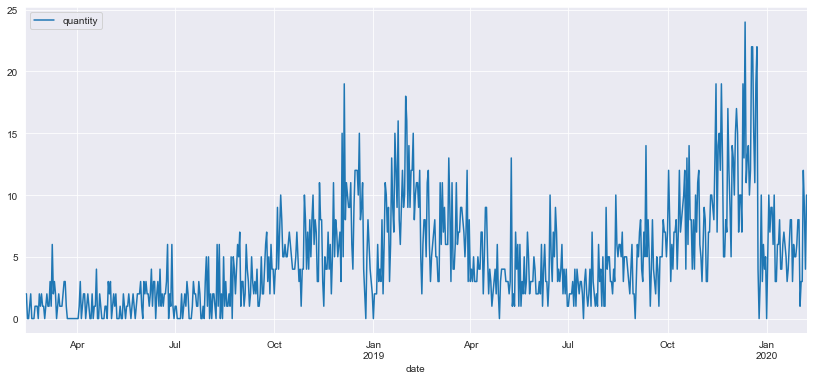

In [450]:
fig, ax = plt.subplots(1, figsize=(14,6))
ax = data[['quantity']].plot(ax=ax)

In [188]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(data.quantity)

0.29321198850417407

In [189]:
'<<2 therefore significant evidence of possitive serial correlation.'

'<<2 therefore significant evidence of possitive serial correlation.'

In [190]:
from statsmodels.tsa.stattools import adfuller
adfuller(data.quantity)

(-3.237226075930715,
 0.017928507566565145,
 7,
 718,
 {'1%': -3.439490435810785,
  '5%': -2.8655738086413374,
  '10%': -2.568918067209286},
 3469.389680407644)

In [191]:
# <5% therefore we reject null hypothesis of unit root, (https://machinelearningmastery.com/time-series-data-stationary-python/)
# so can assume stationary but nor overwhelmingly convincingly, this is not a random walk.
# https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test

'<2 therefore we reject null hypothesis of unit root, this is not a random walk.'

In [237]:
adfuller(data.quantity.diff()[1:]) # <<<5% therefore we reject null hypothesis of unit root, 

(-8.10903003209899,
 1.2402003849457932e-12,
 20,
 704,
 {'1%': -3.4396728750301966,
  '5%': -2.8656541974330936,
  '10%': -2.5689608949670713},
 3470.2699006025987)

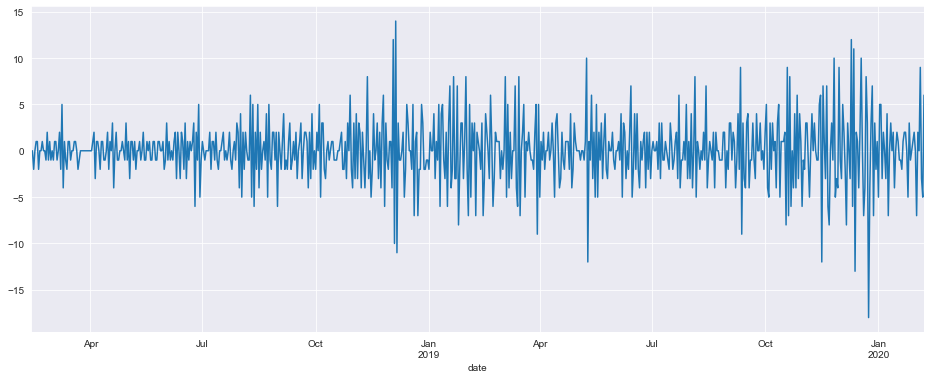

In [247]:
data.quantity.diff().plot()

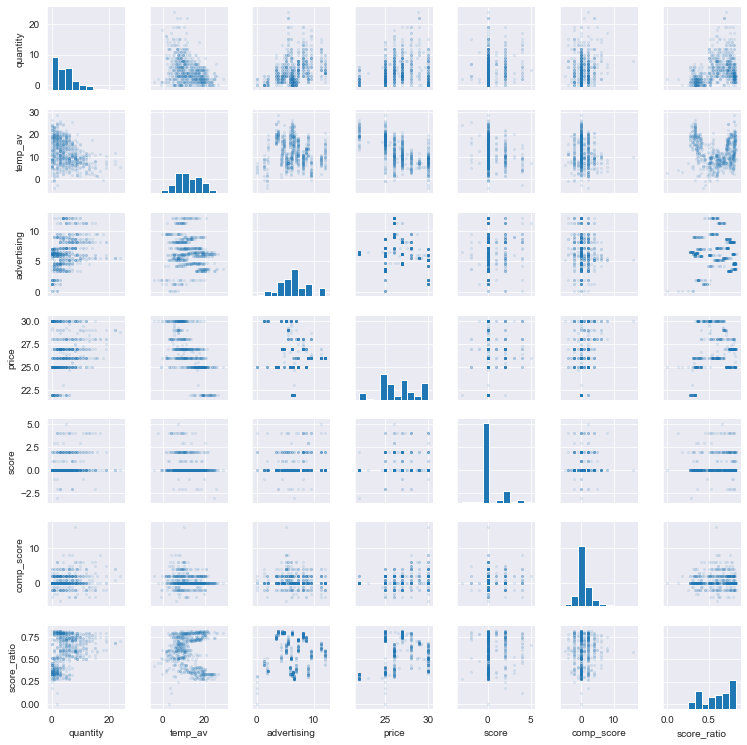

In [472]:
sns.pairplot(
    data[[
        'quantity',
        'temp_av',
        'advertising',
        'price',
        'score',
    #     'score_accum',
        'comp_score',
    #     'comp_score_accum',
        'score_ratio',
#         'we',
    #     'prexmas'
        ]],
    diag_kind = 'hist',
    plot_kws = {'alpha': .1, 's': 5, 'edgecolor': None},
    size = 1.5
)

dow
0    5.048077
1    5.076923
2    5.375000
3    5.028846
4    4.711538
5    4.291262
6    4.475728
Name: quantity, dtype: float64


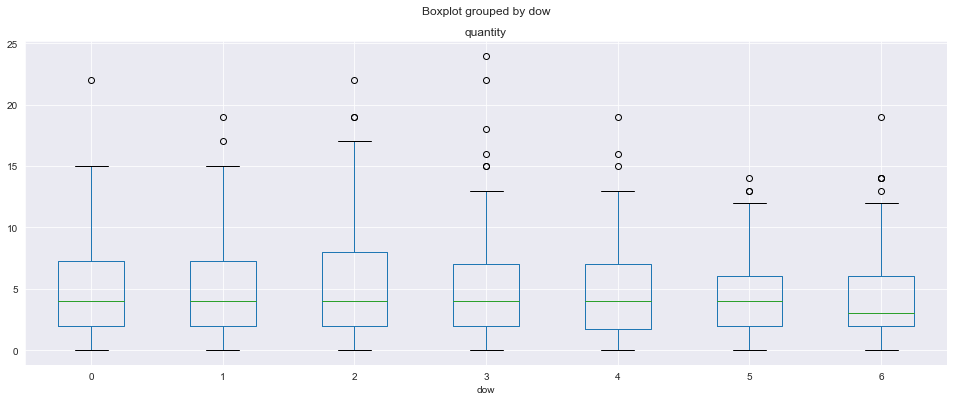

In [192]:
# looking for seasonality
# intra week
print(data.quantity.groupby(data.dow).mean())
data.boxplot(column='quantity', by='dow')

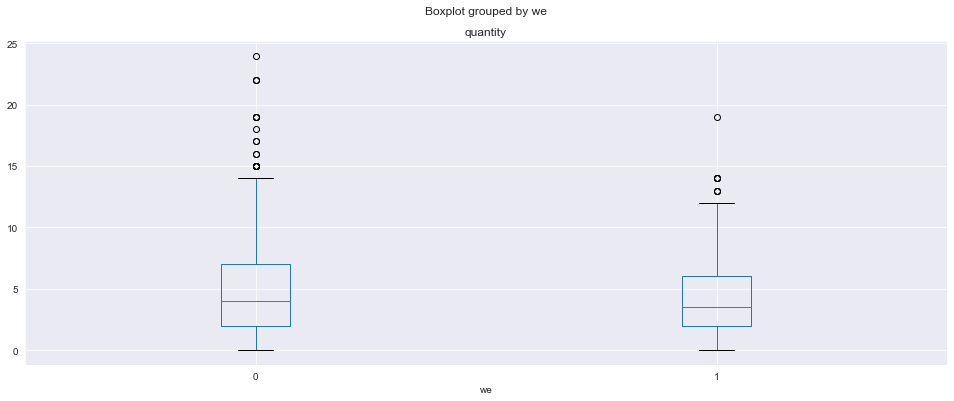

In [203]:
data.boxplot(column='quantity', by='we')

In [206]:
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.diagnostic import kstest_normal
x1 = data.quantity.loc[data.we == 1]
print(kstest_normal(x1, dist='norm', pvalmethod='table'))
x2 = data.quantity.loc[data.we == 0]
print(kstest_normal(x2, dist='norm', pvalmethod='table'))
# ttest_ind(x1, x2, alternative='two-sided', usevar='unequal', weights=(None, None), value=0)


(0.16368252750781975, 0.0009999999999998899)
(0.1333649214557457, 0.0009999999999998899)


In [207]:
# can t test because large samples
# p < 0,05 therefore rejevct that these distributions have the same mean
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.kstest_normal.html

In [208]:
# turns out these are exponential or maybe gaussian distributions
print(kstest_normal(x1, dist='exp', pvalmethod=None))
print(kstest_normal(x2, dist='exp', pvalmethod=None))

(0.14304801143225726, 0.0009999999999998899)
(0.12135225283702678, 0.0009999999999998899)


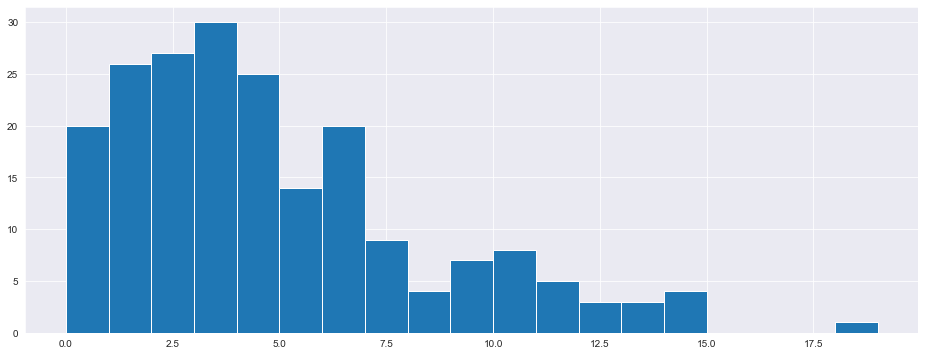

In [210]:
x1.hist(bins=19)

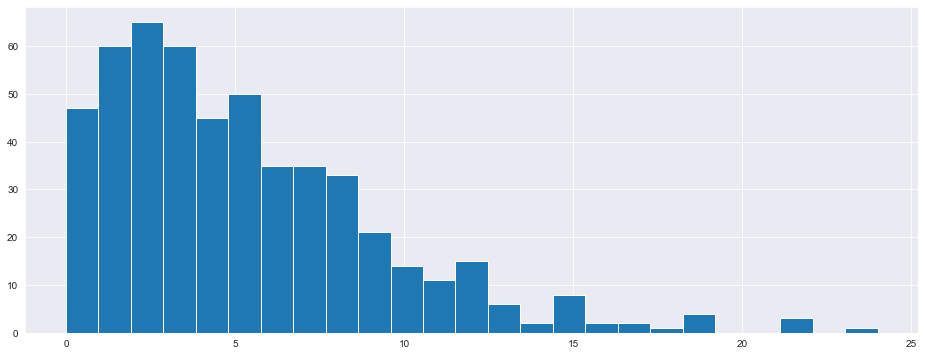

In [211]:
x2.hist(bins=25)

In [212]:
# intra year seasonality
# probably xmas

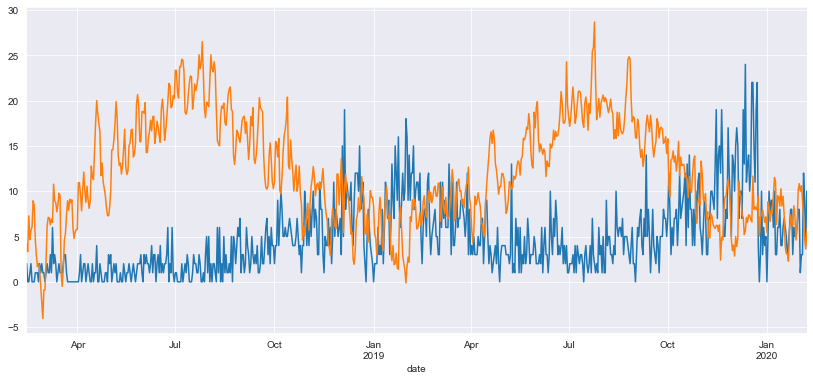

In [213]:
fig, ax = plt.subplots(1, figsize=(14,6))
data.quantity.plot(ax=ax)
data.temp_av.plot(ax=ax)

In [445]:
X = data[['temp_av', 'score_accum']]
X = sm.add_constant(X)
cointegration_model = sm.OLS(data.quantity, X)
result = cointegration_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     159.1
Date:                Sun, 05 Apr 2020   Prob (F-statistic):           5.48e-58
Time:                        14:52:26   Log-Likelihood:                -1918.5
No. Observations:                 726   AIC:                             3843.
Df Residuals:                     723   BIC:                             3857.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2345      0.373     14.027      0.000       4.502       5.967
temp_av        -0.2302      0.022    -10.324      0.000      -0.274      -0.186
score_accum     0.0218      0.002     12.934      0.000       0.018       0.025
==============================================================================
Omnibus:                      113.330   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.894
Skew:                           0.937   Prob(JB):                     1.18e-45
Kurtosis:                       4.824   Cond. No.                         399.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [446]:
residuals = data.quantity - result.predict()
adfuller(residuals)

(-3.813063868481822,
 0.002776447259835403,
 16,
 709,
 {'1%': -3.439606888036868,
  '5%': -2.865625121924057,
  '10%': -2.5689454046801052},
 3464.9340951171666)

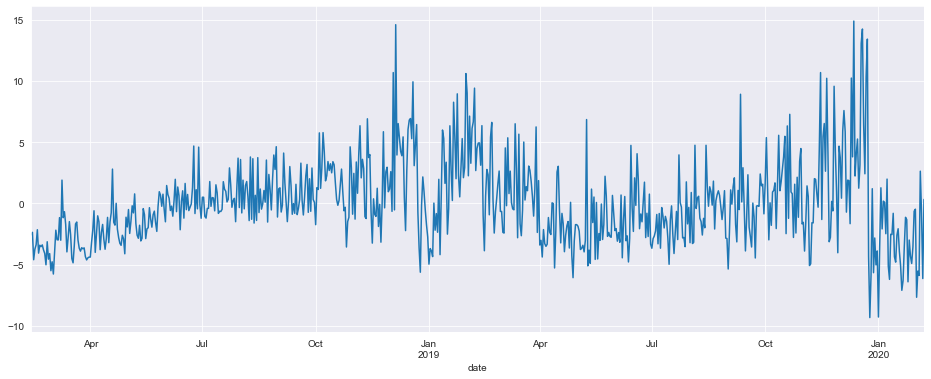

In [468]:
residuals.plot()


In [466]:
cointegrated = data.quantity - result.params['temp_av'] * data.temp_av - result.params['score_accum'] * data.score_accum

In [467]:
adfuller(cointegrated)

(-3.81306386848182,
 0.002776447259835423,
 16,
 709,
 {'1%': -3.439606888036868,
  '5%': -2.865625121924057,
  '10%': -2.5689454046801052},
 3464.934095117166)

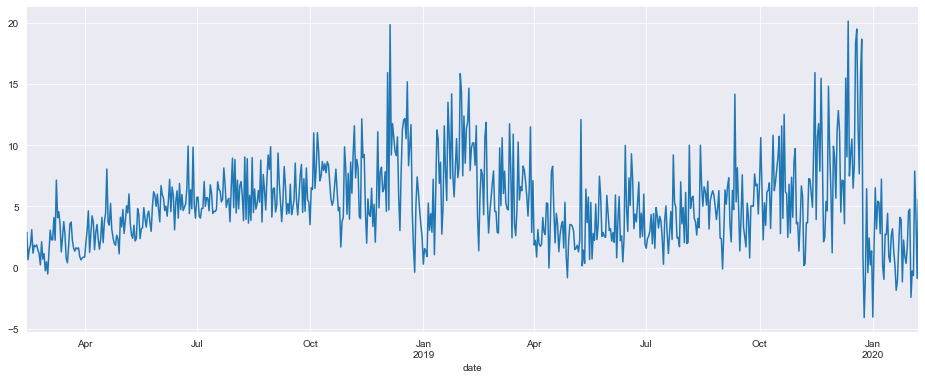

In [469]:
cointegrated.plot()

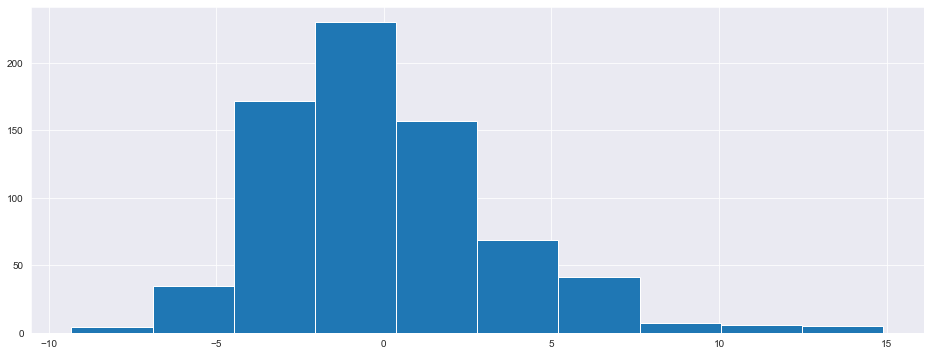

In [448]:
residuals.hist()

In [460]:
from statsmodels.stats.stattools import jarque_bera
list(zip(['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis'], jarque_bera(residuals, axis=0)))

[('Jarque-Bera', 206.89430557262042),
 ('Chi^2 two-tail prob.', 1.1843290342716068e-45),
 ('Skew', 0.9368631797983565),
 ('Kurtosis', 4.824453536077815)]

In [251]:
import numpy as np
import statsmodels.api as sm
from itertools import combinations

In [279]:
def ols_combinations_helper(data, combination):
    y = data.quantity
    x = data[list(combination)]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    return model.fit()

In [405]:
options = [
    'temp_av',
    'advertising',
    'price',
    'score',
    'score_accum',
    'comp_score',
    'comp_score_accum',
    'score_ratio',
    'we',
    'prexmas'
]
results = {}
for i in range(1, 7):
    for combination in combinations(options, i):
        results[combination] = ols_combinations_helper(data, combination).aic
        

In [406]:
ranked_combinations = sorted(results, key=results.get)

In [407]:
ranked_combinations[0]

('temp_av', 'advertising', 'price', 'score_accum', 'we', 'prexmas')

In [408]:
for combination in ranked_combinations:
    print(combination, results[combination])

('temp_av', 'advertising', 'price', 'score_accum', 'we', 'prexmas') 3603.3255959713706
('temp_av', 'advertising', 'price', 'score_accum', 'comp_score_accum', 'prexmas') 3607.5044411921763
('temp_av', 'advertising', 'price', 'score_accum', 'score_ratio', 'prexmas') 3607.7654586064054
('temp_av', 'advertising', 'price', 'score_accum', 'prexmas') 3607.9791065826225
('temp_av', 'advertising', 'price', 'score_accum', 'comp_score', 'prexmas') 3608.974376580939
('temp_av', 'advertising', 'price', 'score', 'score_accum', 'prexmas') 3609.0207532799986
('temp_av', 'advertising', 'price', 'comp_score_accum', 'score_ratio', 'prexmas') 3610.5291658900137
('temp_av', 'advertising', 'score_accum', 'comp_score_accum', 'we', 'prexmas') 3619.235958146185
('temp_av', 'advertising', 'score_accum', 'we', 'prexmas') 3621.3545963854394
('temp_av', 'advertising', 'score_accum', 'score_ratio', 'we', 'prexmas') 3621.6850058429927
('temp_av', 'advertising', 'score', 'score_accum', 'we', 'prexmas') 3622.142189087

In [409]:
best_result = ols_combinations_helper(data, ranked_combinations[0])
best_result.summary()  # durbin watson starting to suggest no serial correlation...

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     122.9
Date:                Sun, 05 Apr 2020   Prob (F-statistic):          1.01e-106
Time:                        12:27:54   Log-Likelihood:                -1794.7
No. Observations:                 726   AIC:                             3603.
Df Residuals:                     719   BIC:                             3635.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4331      2.208      4.725      0.000       6.098      14.768
temp_av        -0.2333      0.026     -9.099      0.000      -0.284      -0.183
advertising     0.4812      0.046     10.534      0.000       0.392       0.571
price          -0.3181      0.071     -4.485      0.000      -0.457      -0.179
score_accum     0.0225      0.001     15.478      0.000       0.020       0.025
we             -0.6103      0.237     -2.573      0.010      -1.076      -0.145
prexmas         6.7502      0.576     11.728      0.000       5.620       7.880
==============================================================================
Omnibus:                      137.185   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.631
Skew:                           0.980   Prob(JB):                     2.41e-75
Kurtosis:                       5.742   Cond. No.                     2.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [410]:
residuals = y - best_result.predict()
adfuller(residuals) # <<<5% therefor stationary

(-9.478045920278678,
 3.940707128107293e-16,
 3,
 722,
 {'1%': -3.439439614524914,
  '5%': -2.865551414233055,
  '10%': -2.5689061365397747},
 3436.5702483879586)

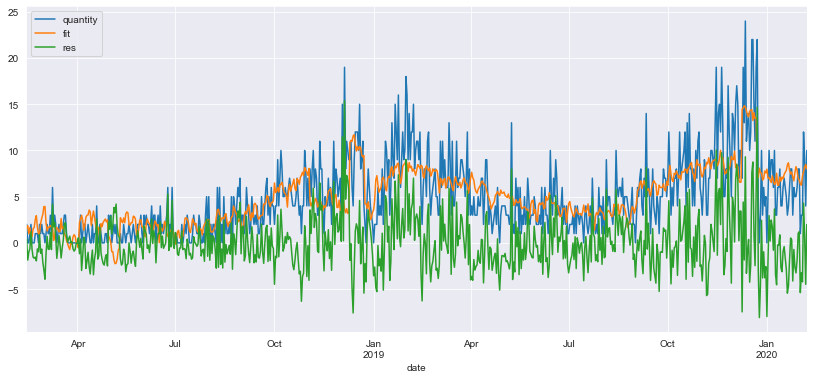

In [411]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = best_result.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

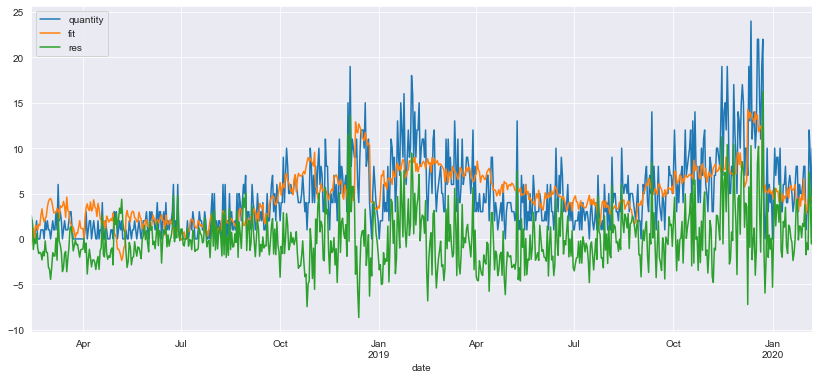

In [391]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = best_result.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

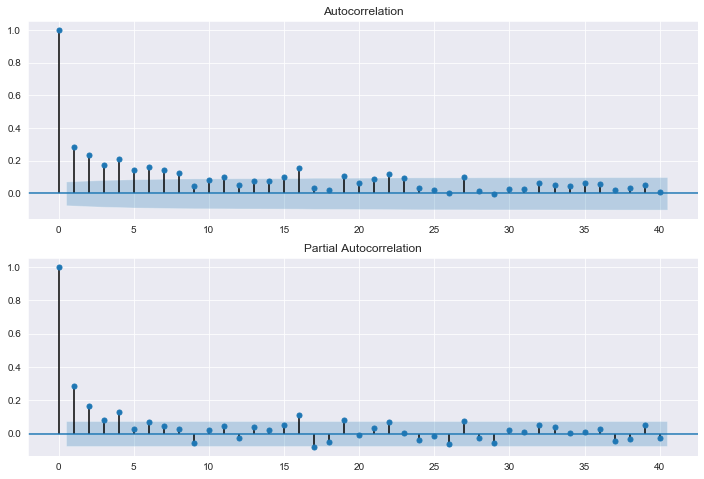

In [392]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
# https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
# https://www.ritchievink.com/blog/2018/09/26/algorithm-breakdown-ar-ma-and-arima-models/
# both the acf and pacf look to tail off suggesting AR and MA

In [393]:
from statsmodels.tsa.arima.model import ARIMA

In [394]:
ranked_combinations[0]

('temp_av', 'advertising', 'price', 'comp_score', 'score_ratio', 'prexmas')

In [395]:
combination = ['temp_av', 'advertising', 'price', 'comp_score', 'score_ratio', 'prexmas'] ## price p > .109 so remove

In [396]:
arima = ARIMA(
    data.quantity,
    order=(1,0,1),
    exog=data[combination]
)
arma_results = arima.fit()
arma_results.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                  726
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1756.850
Date:                Sun, 05 Apr 2020   AIC                           3533.699
Time:                        12:24:12   BIC                           3579.575
Sample:                    02-12-2018   HQIC                          3551.403
                         - 02-07-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4075      5.969      1.241      0.215      -4.291      19.106
temp_av        -0.1065      0.043     -2.453      0.014      -0.192      -0.021
advertising     0.0226      0.141      0.161      0.872      -0.253       0.298
price          -0.2215      0.188     -1.179      0.239      -0.590       0.147
comp_score      0.0417      0.048      0.869      0.385      -0.052       0.136
score_ratio     7.3054      3.857      1.894      0.058      -0.255      14.866
prexmas         4.6565      0.400     11.643      0.000       3.873       5.440
ar.L1           0.9750      0.010     94.116      0.000       0.955       0.995
ma.L1          -0.8148      0.025    -32.476      0.000      -0.864      -0.766
sigma2          7.3939      0.287     25.800      0.000       6.832       7.956
===================================================================================
Ljung-Box (Q):                       54.60   Jarque-Bera (JB):               236.58
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [397]:
residuals = y - arma_results.predict()
print(durbin_watson)
adfuller(residuals) # <<<5% therefor positive serial correlation SAME AS TEST ABOVE 


<function durbin_watson at 0x10e591170>


(-25.480892593071584,
 0.0,
 0,
 725,
 {'1%': -3.4394018678958544,
  '5%': -2.865534780932388,
  '10%': -2.5688972751486325},
 3428.2529315760175)

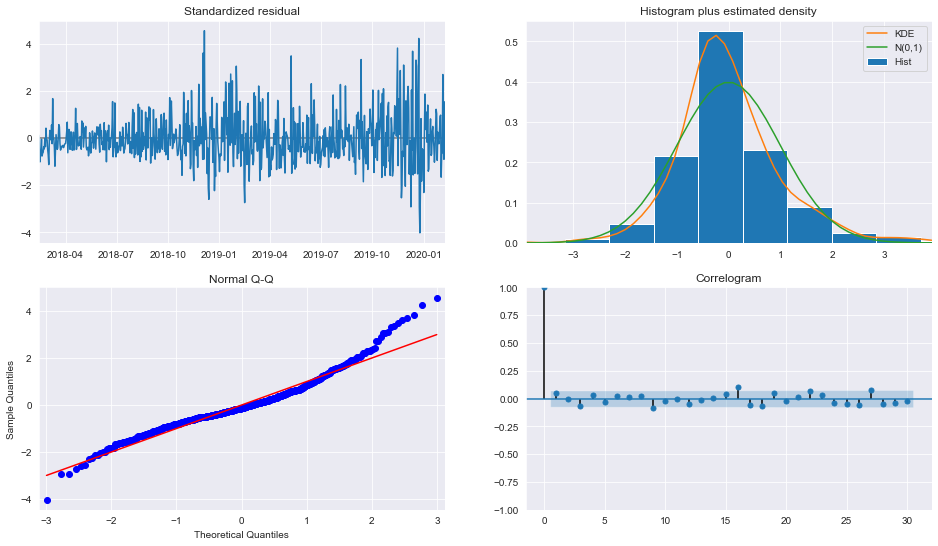

In [398]:
fig = plt.figure(figsize=(16,9))
fig = arma_results.plot_diagnostics(fig=fig, lags=30)

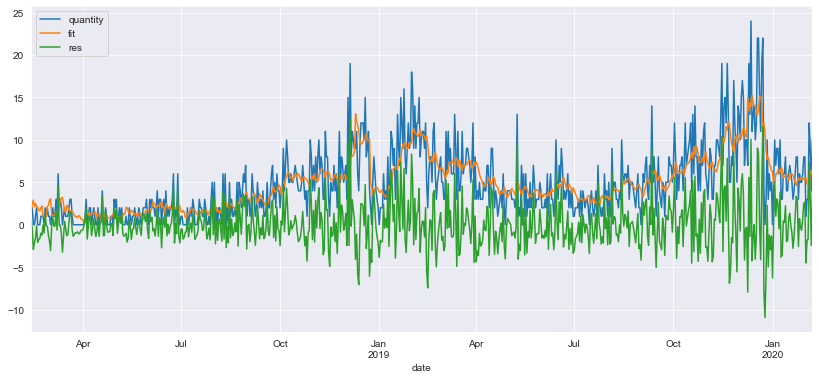

In [399]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = arma_results.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

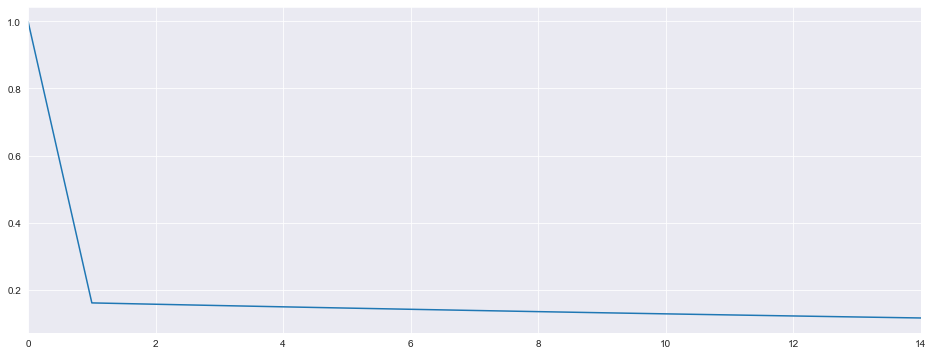

In [400]:
arma_results.impulse_responses(steps=14).plot()

In [401]:
arima = ARIMA(
    data.quantity,
    order=(3,0,3),
    exog=data[list(ranked_combinations[0])]
)
arma_results = arima.fit()
arma_results.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                  726
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1752.977
Date:                Sun, 05 Apr 2020   AIC                           3533.954
Time:                        12:25:01   BIC                           3598.180
Sample:                    02-12-2018   HQIC                          3558.739
                         - 02-07-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.1516      5.967      1.366      0.172      -3.544      19.847
temp_av        -0.1130      0.045     -2.502      0.012      -0.202      -0.024
advertising     0.0136      0.138      0.099      0.921      -0.256       0.283
price          -0.2559      0.188     -1.360      0.174      -0.624       0.113
comp_score      0.0261      0.047      0.549      0.583      -0.067       0.119
score_ratio     7.8788      3.854      2.044      0.041       0.325      15.432
prexmas         4.7666      0.411     11.596      0.000       3.961       5.572
ar.L1          -0.0704      0.279     -0.253      0.800      -0.616       0.476
ar.L2           0.8235      0.101      8.176      0.000       0.626       1.021
ar.L3           0.2038      0.270      0.756      0.450      -0.325       0.732
ma.L1           0.2863      0.273      1.047      0.295      -0.250       0.822
ma.L2          -0.6534      0.109     -6.016      0.000      -0.866      -0.440
ma.L3          -0.2741      0.218     -1.258      0.209      -0.701       0.153
sigma2          7.3163      0.287     25.521      0.000       6.754       7.878
===================================================================================
Ljung-Box (Q):                       48.41   Jarque-Bera (JB):               246.30
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               4.57   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

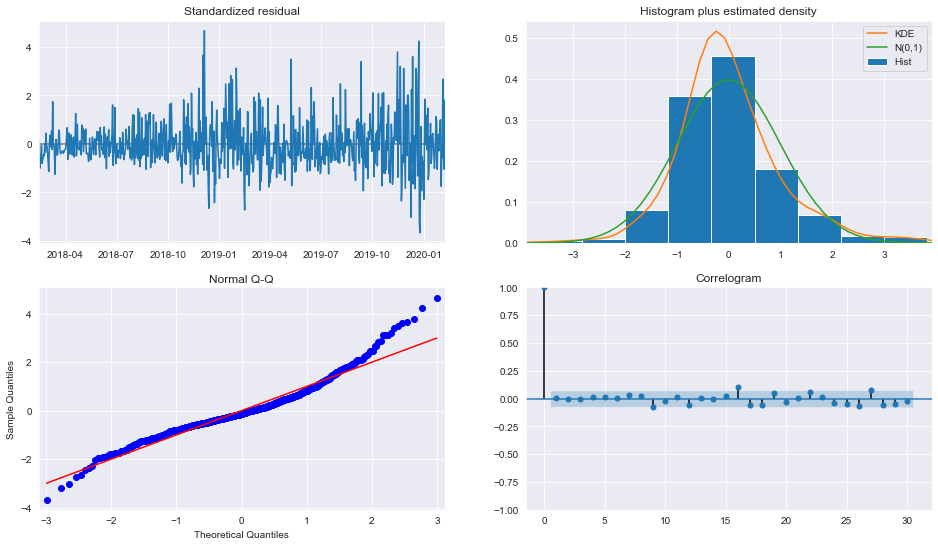

In [402]:
fig = plt.figure(figsize=(16,9))
fig = arma_results.plot_diagnostics(fig=fig, lags=30)

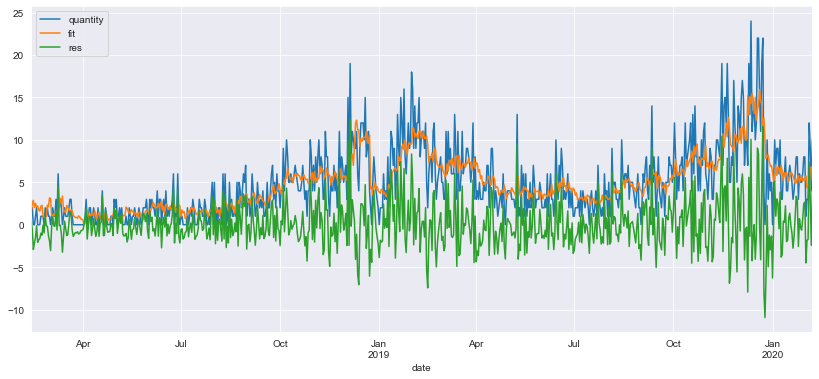

In [403]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = arma_results.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

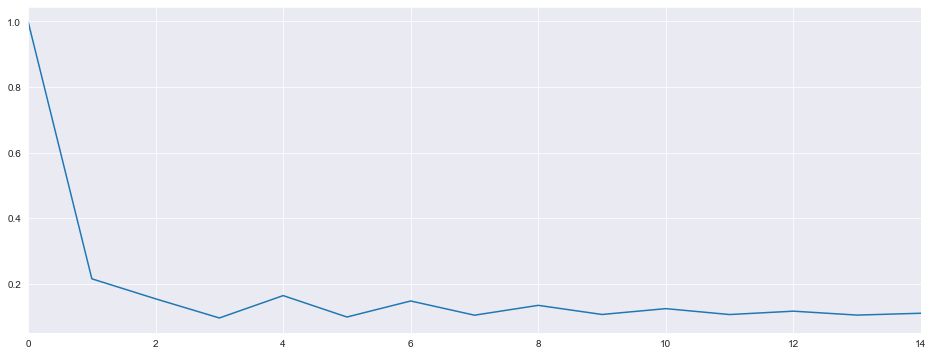

In [404]:
arma_results.impulse_responses(steps=14).plot()

In [ ]:
weekly_sales = data.resample('W-MON').agg(
    {
        'price': 'mean',
        'quantity': 'sum',
        'advertising': 'sum',
        'temp_av': 'mean',
        'score': 'sum',
        'comp_score': 'sum',        
    })
weekly_sales['quantity_diff'] = weekly_sales.quantity.diff()
weekly_sales['score_ratio'] = weekly_sales.score / weekly_sales.comp_score
weekly_sales.dropna(inplace=True)

weekly_sales.head()

In [ ]:
fig, ax = plt.subplots(3, figsize=(14,12))
ax[0] = weekly_sales.quantity.plot(ax=ax[0])
ax[1] = weekly_sales.quantity_diff.plot(ax=ax[1])
ax[2] = weekly_sales.quantity.pct_change().plot(ax=ax[2])

In [ ]:
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)
stl = STL(weekly_sales.quantity_diff.dropna(), seasonal=7)
res = stl.fit()
fig = res.plot()

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_sales.quantity, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_sales.quantity, lags=40, ax=ax2)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(weekly_sales.quantity.diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(weekly_sales.quantity.diff().dropna(), lags=40, ax=ax2)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
arima = ARIMA(
    weekly_sales.quantity,
    order=(1,1,1),
    exog=weekly_sales[['temp_av', 'advertising', 'price', 'score', 'comp_score']]
)
arima.exog_names

In [181]:
res = arima.fit()

In [ ]:
res.summary()

In [182]:
res

In [ ]:
mod = AutoReg(data.quantity.diff().dropna(), 5)
res = mod.fit()
res.summary()

In [ ]:
from statsmodels.tsa.stattools import adfuller
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller
adfuller(weekly_sales.quantity, maxlag=0, regression='c', autolag=None, store=False, regresults=False)

In [183]:
data.head()

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,week,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,
2018-02-12,2018-02-12,24.99,2.0,0.040417,2.944444,0.0,0.0,0.0,32.0,0.000000,2018_07,0,0,0,0
2018-02-13,2018-02-13,24.99,2.0,0.040417,4.166667,4.0,0.0,4.0,32.0,0.125000,2018_07,0,0,1,0
2018-02-14,2018-02-14,24.99,0.0,0.040417,3.333333,2.0,2.0,6.0,34.0,0.176471,2018_07,0,0,2,0
2018-02-15,2018-02-15,24.99,0.0,0.040417,7.277778,2.0,-2.0,8.0,32.0,0.250000,2018_07,0,0,3,0
2018-02-16,2018-02-16,24.99,1.0,0.040417,4.666667,2.0,0.0,10.0,32.0,0.312500,2018_07,0,0,4,0


In [ ]:
wa = data.temp_av * data.advertising
ws = data.temp_av * data.score_accum
ws = 